In [1]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
import matplotlib.pyplot as plt
import pickle
data_dir = '/home/ruizhew/POSEIDON/POSEIDON/reference_data/observations/WASP-76b'
data = read_high_res_data(data_dir, method='sysrem', spectrum_type='transmission')
data_raw = data['data_raw']
data_raw[data_raw < 0] = 0
Ndet, Nphi, Npix = data_raw.shape
wl_grid = data['wl_grid']

In [20]:
C_norm = np.zeros(data_raw.shape)
for k in range(Ndet):
    order = data_raw[k]
    
    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = (order / median)
    C_norm[k] = order_norm

In [22]:
from scipy.ndimage import gaussian_filter1d, median_filter
for det in range(Ndet):
    for phi in range(Nphi):
        C_norm[det][phi] = median_filter(C_norm[det][phi], size=501)

for det in range(Ndet):
    for phi in range(Nphi):
        C_norm[det][phi] = gaussian_filter1d(C_norm[det][phi], sigma=100)

In [23]:
data_blaze_corrected = data_raw / C_norm

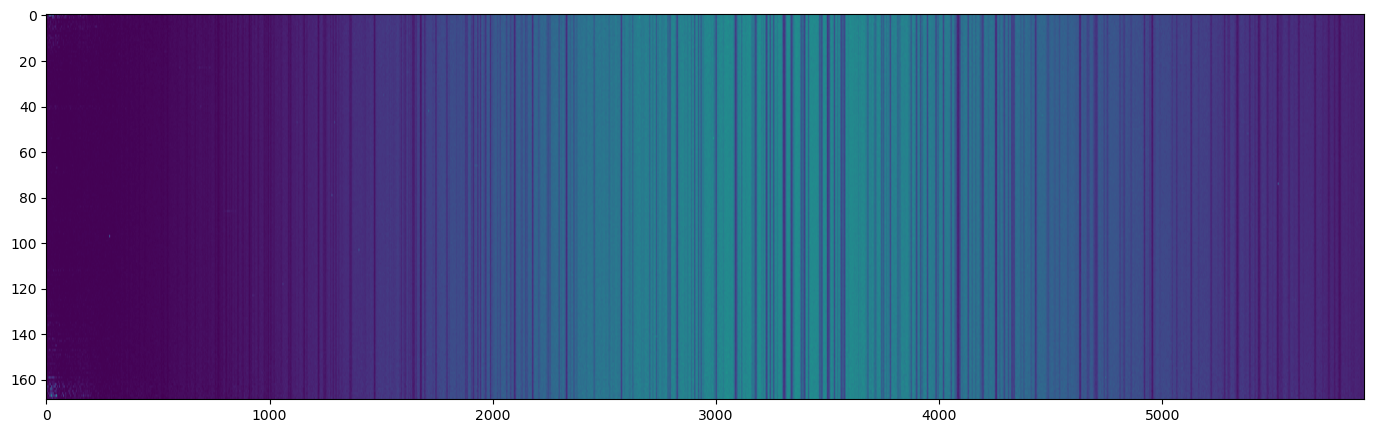

In [25]:
plt.figure(figsize=(17,5))
plt.imshow(data_blaze_corrected[0], aspect='auto')

In [27]:
uncertainties = fit_uncertainties(data_blaze_corrected, NPC=5)

/home/ruizhew/.conda/envs/poseidon/lib/python3.9/site-packages/POSEIDON/high_res.py:512: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(a * data_raw[i] + b)


In [34]:
pickle.dump(uncertainties, open('./reference_data/observations/WASP-76b/uncertainties.pic', 'wb'))
pickle.dump([wl_grid, data_blaze_corrected], open('./reference_data/observations/WASP-76b/data_RAW.pic', 'wb'))

In [35]:
import pickle
output_path = './CC_output/WASP-76b' # Could modify output path here.
data_path = './reference_data/observations/WASP-76b'
# uncertainties = fit_uncertainties(data_raw, NPC=5)
uncertainties = pickle.load(open(data_path+'/uncertainties.pic', 'rb'))
data = read_high_res_data(data_dir, method='sysrem', spectrum_type='transmission')['data_raw']

In [36]:
from POSEIDON.high_res import fast_filter
for i in range(len(data)):
    order = data[i]
    
    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = order / median

    uncertainty = uncertainties[i]

    uncertainty_norm = uncertainty / median
    
    uncertainties[i] = uncertainty_norm
    data[i] = order_norm

residuals, Us = fast_filter(data, uncertainties, iter=15)

/tmp/ipykernel_79712/3630367577.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(output_path+'filtered.pdf', fmt='pdf')


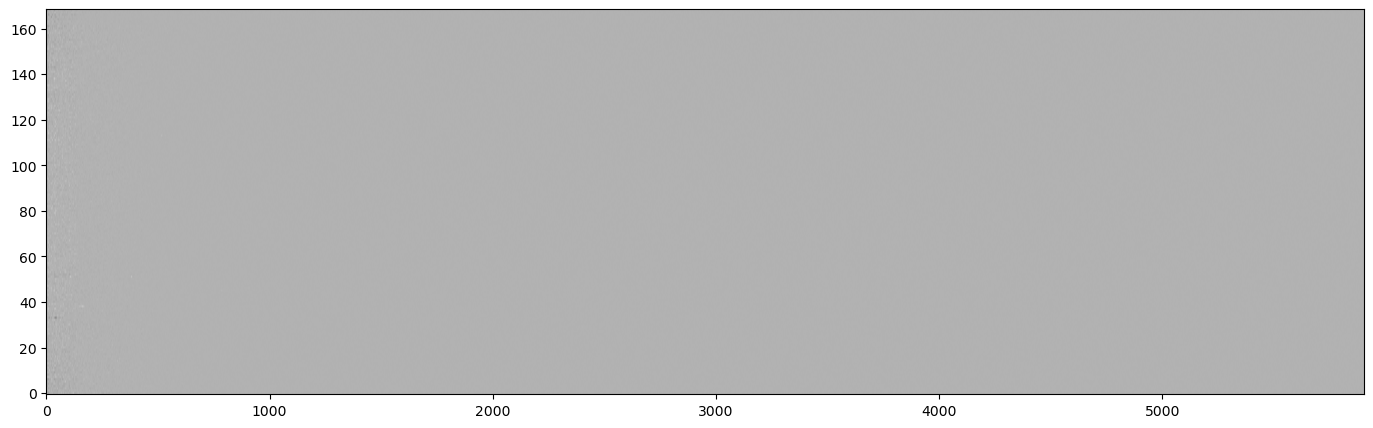

In [40]:
plt.figure(figsize=(17,5))
plt.imshow(residuals[2], aspect='auto', origin='lower', cmap='gray')
plt.savefig(output_path+'filtered.pdf', fmt='pdf')

In [214]:
Bs = np.zeros((Ndet, Nphi, Nphi))

for j in range(Ndet):
    U = Us[j]
    L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
    B = U @ np.linalg.pinv(L @ U) @ L
    Bs[j] = B

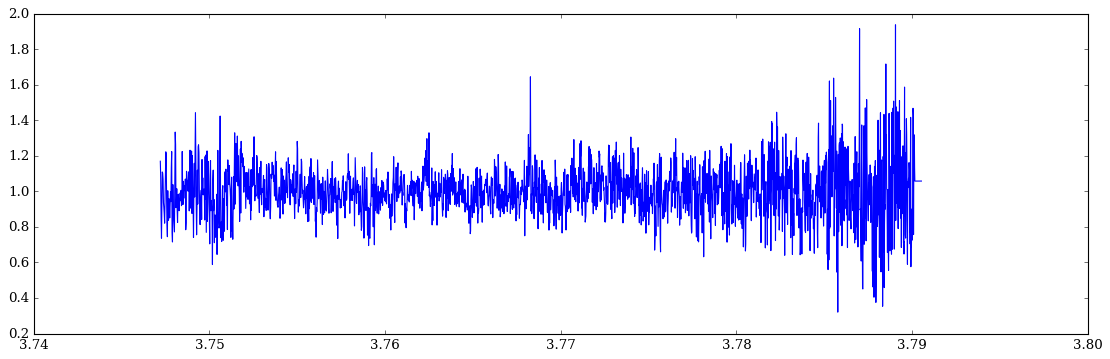

In [215]:
plt.figure(figsize=(17,5))
plt.plot(wl_grid[0], residuals[0][50])
plt.ticklabel_format(useOffset=False)

In [216]:
j = 15
models_shifted = models_shifted[j]

In [217]:
models_shifted = (models_shifted.T / np.median(models_shifted, axis=1)).T
B = Bs[j]
model_filtered = models_shifted - B @ models_shifted